<a id=top-page></a>
# `pykitPIV` demo: Generate synthetic BOS images

In this Jupyter notebook, we show how `pykitPIV` can be used as a synthetic BOS image generator. This notebook shows the full workflow that uses the four classes in a sequence:

`Particle` $\rightarrow$ `FlowField` $\rightarrow$ `Motion` $\rightarrow$ `Image`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import cmcrameri.cm as cmc

from pykitPIV import Particle, FlowField, Motion, Image

2025-05-05 20:09:33.779331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
save_images = False
n_images = 1
image_size = (100, 100)
size_buffer = 0
origin = 'lower'
figsize = (6,6)
filename = None

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [64]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=4,
                     distances=5,
                     densities=1.2,
                     diameter_std=0,
                     seeding_mode='poisson',
                     random_seed=100)

In [65]:
image = Image(random_seed=100)

In [66]:
image.add_particles(particles)

In [95]:
image.add_reflected_light(exposures=0.99,
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          no_laser_plane=True,
                          alpha=1/4,
                          extend_gaussian=3)

In [96]:
image.exposures_per_image

array([0.99])

In [97]:
particles.n_of_particles

[561]

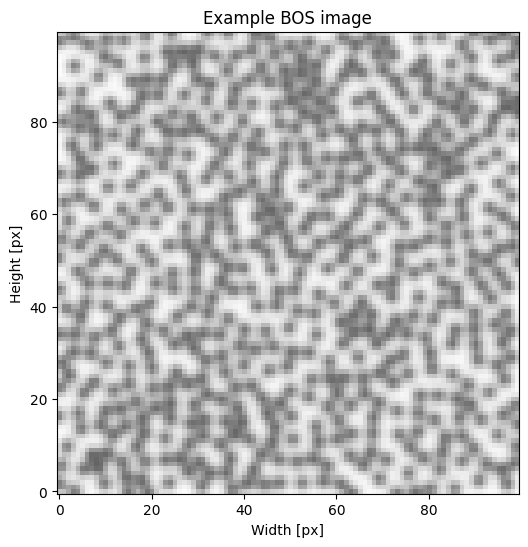

In [98]:
if save_images: filename = 'example-image.png'
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example BOS image', 
           cmap='Greys',
           origin=origin,
           figsize=figsize, 
           filename=filename);

<a id=generate-velocity-field></a>
***

## Generate random velocity field to advect the particles

[Go to the top](#top-page)

In [ ]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=100)

In [ ]:
flowfield.print_available_fields()

In [ ]:
flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                         n_gaussian_filter_iter=20,
                                         displacement=(0,10))

In [ ]:
image.add_flowfield(flowfield)

In [ ]:
if save_images: filename = 'example-random-velocity-field.png'
image.plot_field(0,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('Example random velocity component $u$', 'Example random velocity component $v$'),
                 cmap=cmc.oslo_r,
                 origin=origin,
                 figsize=figsize,
                 filename=filename);

In [ ]:
if save_images: filename = 'example-random-velocity-field-magnitude.png'
image.plot_field_magnitude(0,
                           with_buffer=True,
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

In [ ]:
if save_images: filename = 'example-random-velocity-field-magnitude-quiver.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

In [ ]:
if save_images: filename = 'example-random-velocity-field-magnitude-streamplot.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=1,
                           streamplot_color='g',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

<a id=add-movement></a>
***

## Add movement to particles

[Go to the top](#top-page)

In [ ]:
motion = Motion(particles, 
                flowfield, 
                time_separation=1)

In [ ]:
motion.forward_euler(n_steps=10)

In [ ]:
if save_images: filename = 'particle-displacement-1.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

<a id=add-movement-update-time-sep></a>

#### Update time separation:

[Go to the top](#top-page)

In [ ]:
motion.time_separation = 2

In [ ]:
motion.forward_euler(n_steps=10)

In [ ]:
if save_images: filename = 'particle-displacement-2.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

In [ ]:
motion.runge_kutta_4th(n_steps=10)

In [ ]:
if save_images: filename = 'particle-displacement-RK4.png'
motion.plot_particle_motion(0,
                            s=4,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename=filename);

<a id=add-movement-visualize></a>

#### Visualize the PIV image pair:

[Go to the top](#top-page)

In [ ]:
image.add_motion(motion)

In [ ]:
if save_images: filename = 'displacement-field.png'
image.plot_field(0,
                 field='displacement',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('Displacement $dx$', 'Displacement $dy$'),
                 cmap=cmc.lajolla,
                 origin=origin,
                 figsize=figsize,
                 filename=filename);

In [ ]:
if save_images: filename = 'displacement-field-magnitude.png'
image.plot_field_magnitude(0,
                           field='displacement',
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=0.5,
                           streamplot_color='w',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Displacement field magnitude',
                           cmap=cmc.lajolla,
                           figsize=figsize,
                           filename=filename);

In [ ]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

In [ ]:
if save_images: filename = 'example-image-I1-with-buffer.png'
image.plot(0, 
           instance=1,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image $I_1$',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

In [ ]:
if save_images: filename = 'example-image-I2-with-buffer.png'
image.plot(0, 
           instance=2,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image $I_2$',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

In [ ]:
if save_images: filename = 'example-image-I1-I2-no-buffer.png'
image.plot_image_pair(0,
                      with_buffer=False, 
                      xlabel='Width [px]',
                      ylabel='Height [px]',
                      title='Example PIV image pair $(I_1, I_2)$',
                      cmap=cmc.oslo,
                      origin=origin,
                      figsize=figsize, 
                      dpi=600,
                      filename=filename);

In [ ]:
if save_images: filename = 'animated-images.gif'
image.animate_image_pair(0, 
                         with_buffer=False, 
                         xlabel='Width [px]',
                         ylabel='Height [px]',
                         title=None, 
                         cmap='Greys_r', 
                         origin=origin,
                         figsize=(5, 5), 
                         dpi=300, 
                         filename=filename);

<a id=save></a>
***

## Save the dataset

[Go to the top](#top-page)

Note, that at the last stage of the PIV image generation we may want to remove buffers from the images and the associated flow targets by running the `Image.remove_buffers()` function:

In [ ]:
images_I1 = image.remove_buffers(image.images_I1)
images_I2 = image.remove_buffers(image.images_I2)

In [ ]:
velocity_field = image.remove_buffers(image.get_velocity_field())
displacement_field = image.remove_buffers(image.get_displacement_field())

In [ ]:
images_intensities = image.concatenate_tensors((images_I1, images_I2))

In [ ]:
flow_targets = image.concatenate_tensors((velocity_field, displacement_field))

In [ ]:
tensors_dictionary = {"I"      : images_intensities, 
                      "target" : flow_targets}

In [ ]:
image.save_to_h5(tensors_dictionary, 
                 filename='pykitPIV-tutorial-PIV-pairs.h5')

<a id=upload></a>
***

## Upload the saved dataset

[Go to the top](#top-page)

The standalone import of previously saved PIV image pairs and the associated targets can be performed following this minimal example:

In [ ]:
from pykitPIV import Image

In [ ]:
image = Image()

In [ ]:
tensors_dictionary_uploaded = image.upload_from_h5(filename='pykitPIV-tutorial-PIV-pairs.h5')

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)